In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

RANDOM_STATE = 42


In [2]:
DATA_PATH = r"D:\Coding\VanetUAV\data\processed\cicids_10pct_stratified.csv"

df = pd.read_csv(DATA_PATH)

df.shape


(283074, 84)

In [3]:
LABEL_COLS = ["Label", "label_bin", "source_file", "day", "attack_group"]

X = df.drop(columns=LABEL_COLS)
y = df["label_bin"]

X.shape, y.shape


((283074, 79), (283074,))

In [4]:
X = X.select_dtypes(include=["int64", "float64"])

X.shape


(283074, 79)

In [5]:
# Replace inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop columns with too many NaNs (>5%)
nan_ratio = X.isna().mean()
cols_to_drop = nan_ratio[nan_ratio > 0.05].index.tolist()

print("Dropping columns due to NaNs:", cols_to_drop)

X = X.drop(columns=cols_to_drop)

# Drop remaining rows with NaN
X = X.dropna()

y = y.loc[X.index]

X.shape


Dropping columns due to NaNs: []


(282808, 79)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape


(282808, 79)

In [7]:
pca = PCA(random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained_var = np.cumsum(pca.explained_variance_ratio_)


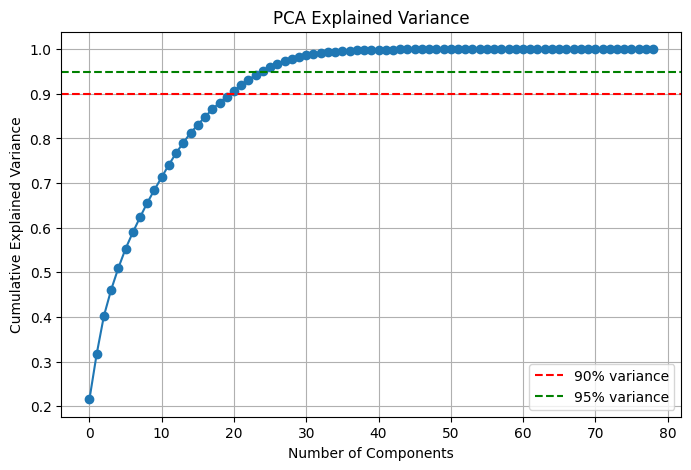

In [8]:
plt.figure(figsize=(8,5))
plt.plot(explained_var, marker="o")
plt.axhline(0.90, linestyle="--", color="red", label="90% variance")
plt.axhline(0.95, linestyle="--", color="green", label="95% variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
n_90 = np.argmax(explained_var >= 0.90) + 1
n_95 = np.argmax(explained_var >= 0.95) + 1

n_90, n_95


(np.int64(21), np.int64(25))

In [10]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Importance = sum of absolute loadings for top N PCs
TOP_PCS = n_90  # or n_95 if you want stricter

feature_importance = loadings.iloc[:, :TOP_PCS].abs().sum(axis=1)

feature_importance = feature_importance.sort_values(ascending=False)

feature_importance.head(20)


Idle Std                   2.394668
Active Min                 2.278607
FIN Flag Count             2.149707
Flow IAT Min               2.055641
Init_Win_bytes_backward    2.032300
Active Std                 2.021711
SYN Flag Count             2.014766
Fwd PSH Flags              2.014766
Down/Up Ratio              2.002133
PSH Flag Count             1.923817
Active Mean                1.905550
Bwd IAT Std                1.857218
Fwd Packets/s              1.798508
Flow Packets/s             1.797449
Bwd Packets/s              1.762734
Min Packet Length          1.762038
Active Max                 1.761165
Bwd IAT Total              1.753162
URG Flag Count             1.744007
Fwd Packet Length Min      1.731181
dtype: float64

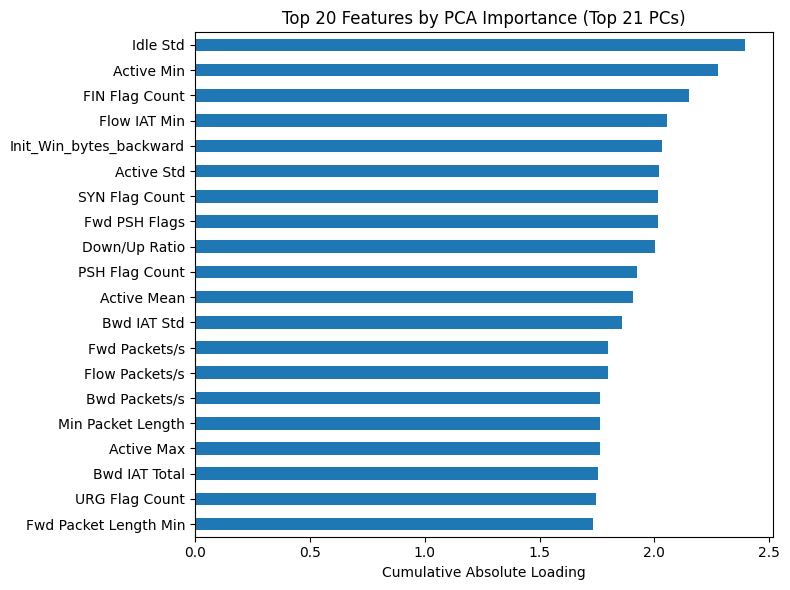

In [11]:
top_k = 20

plt.figure(figsize=(8,6))
feature_importance.head(top_k).iloc[::-1].plot(kind="barh")
plt.title(f"Top {top_k} Features by PCA Importance (Top {TOP_PCS} PCs)")
plt.xlabel("Cumulative Absolute Loading")
plt.tight_layout()
plt.show()


In [12]:
low_importance = feature_importance[feature_importance < feature_importance.quantile(0.25)]

len(low_importance), low_importance.index.tolist()


(20,
 ['Avg Bwd Segment Size',
  'Bwd Packet Length Mean',
  'Packet Length Std',
  'Bwd Packet Length Max',
  'Max Packet Length',
  'Total Length of Bwd Packets',
  'Subflow Bwd Bytes',
  'Total Backward Packets',
  'Subflow Bwd Packets',
  'Total Fwd Packets',
  'Subflow Fwd Packets',
  'act_data_pkt_fwd',
  'Bwd PSH Flags',
  'Bwd URG Flags',
  'Fwd Avg Bytes/Bulk',
  'Bwd Avg Bytes/Bulk',
  'Fwd Avg Bulk Rate',
  'Fwd Avg Packets/Bulk',
  'Bwd Avg Bulk Rate',
  'Bwd Avg Packets/Bulk'])

In [13]:
OUTPUT_PATH = r"D:\Coding\VanetUAV\data\processed\pca_feature_importance.csv"

feature_importance.to_csv(OUTPUT_PATH, header=["importance"])

print("Saved PCA feature importance to:")
print(OUTPUT_PATH)


Saved PCA feature importance to:
D:\Coding\VanetUAV\data\processed\pca_feature_importance.csv


In [15]:
DROP_FEATURES = [
    # Bulk / artificial (almost always zero)
    "Fwd Avg Bytes/Bulk",
    "Fwd Avg Packets/Bulk",
    "Fwd Avg Bulk Rate",
    "Bwd Avg Bytes/Bulk",
    "Bwd Avg Packets/Bulk",
    "Bwd Avg Bulk Rate",

    # Backward mirrors (redundant)
    "Bwd Packet Length Mean",
    "Bwd Packet Length Max",
    "Avg Bwd Segment Size",
    "Total Length of Bwd Packets",
    "Total Backward Packets",
    "Subflow Bwd Packets",
    "Subflow Bwd Bytes",

    # Redundant forward mirrors
    "Total Fwd Packets",
    "Subflow Fwd Packets",

    # Low-signal flags
    "Bwd PSH Flags",
    "Bwd URG Flags",

    # Weak structural features
    "Packet Length Std",
    "Max Packet Length",
    "act_data_pkt_fwd"
]


In [16]:
PRUNED_PATH = r"D:\Coding\VanetUAV\data\processed\cicids_10pct_pruned.csv"

df_pruned = df.drop(columns=DROP_FEATURES)

print("Original shape:", df.shape)
print("Pruned shape:", df_pruned.shape)

df_pruned.to_csv(PRUNED_PATH, index=False)

print("Saved pruned dataset to:")
print(PRUNED_PATH)


Original shape: (283074, 84)
Pruned shape: (283074, 64)
Saved pruned dataset to:
D:\Coding\VanetUAV\data\processed\cicids_10pct_pruned.csv
